In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Activation, Dropout, Concatenate
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
# For loading data from drive onto google colab
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# If running locally, include the dataset in the same folder

Mounted at /content/drive


In [3]:
# To unzip the dataset (change the path accordingly)
!unzip /content/drive/MyDrive/Post-hurricane.zip -d hurricane_data

Streaming output truncated to the last 5000 lines.
  inflating: hurricane_data/train_another/no_damage/-95.62751800000001_29.857785999999997.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.62751999999999_29.860796999999998.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.627523_29.770004999999998.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.62753000000001_29.863289.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.627539_29.827047999999998.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.627543_29.860021000000003.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.627563_29.8628.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.627579_29.864051.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.627595_29.776602.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.62759799999999_29.777317.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.62760300000001_29.

In [4]:
#To set train, test and validation path
DIR = '/content/hurricane_data'
train_path = os.path.join(DIR, 'train_another')
val_path = os.path.join(DIR, 'validation_another')
test_path = os.path.join(DIR, 'test')

In [5]:
image_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


Loading with Image Augmentation
This will create more variation in the training dataset to reduce model overfitting and improve performance.

In [6]:
image_size = (128, 128)
batch_size = 100

# TRAINING
# specify training image transformations
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

# keras generator for training data
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')


# VALIDATION
# specify validation image transformations (rescale only)
val_datagen = ImageDataGenerator(rescale=1./255)

# keras generator for validation data
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [7]:
def plot_nn_training(history):

    '''Given model training history, plots validation accuracy and loss'''

    # plot history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # plot history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Baseline Model - No Image Augmentation

In [8]:
model = Sequential()

# scaling
model.add(Rescaling(1.0 / 255))

# convolution layers
model.add(Conv2D(32, kernel_size=5, strides=2, padding="same", input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

# flatten
model.add(Flatten())

# dense layers
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# output layer
model.add(Dense(2, activation='softmax'))

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model1/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [10]:
results1 = model.fit(
    train_ds,
    epochs=50,
    callbacks= [es, mc],
    validation_data=val_ds,
    verbose=4)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.50200, saving model to models/Model1/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50

Epoch 2: val_accuracy improved from 0.50200 to 0.89300, saving model to models/Model1/best_model.h5
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.89300
Epoch 4/50

Epoch 4: val_accuracy improved from 0.89300 to 0.89700, saving model to models/Model1/best_model.h5
Epoch 5/50

Epoch 5: val_accuracy improved from 0.89700 to 0.90750, saving model to models/Model1/best_model.h5
Epoch 6/50

Epoch 6: val_accuracy did not improve from 0.90750
Epoch 7/50

Epoch 7: val_accuracy did not improve from 0.90750
Epoch 8/50

Epoch 8: val_accuracy did not improve from 0.90750
Epoch 9/50

Epoch 9: val_accuracy did not improve from 0.90750
Epoch 10/50

Epoch 10: val_accuracy did not improve from 0.90750
Epoch 11/50

Epoch 11: val_accuracy did not improve from 0.90750
Epoch 12/50

Epoch 12: val_accuracy did not improve from 0.90750
Epoch 13/50

Epoch 13: val_accuracy improved from 0.90750 to 0.94750, saving model to models/Model1/best_model.h5
Epoch 14/50

Epoch 14: val_accuracy did 

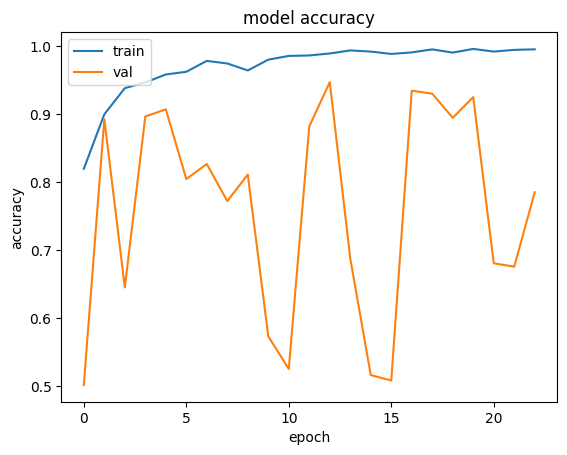

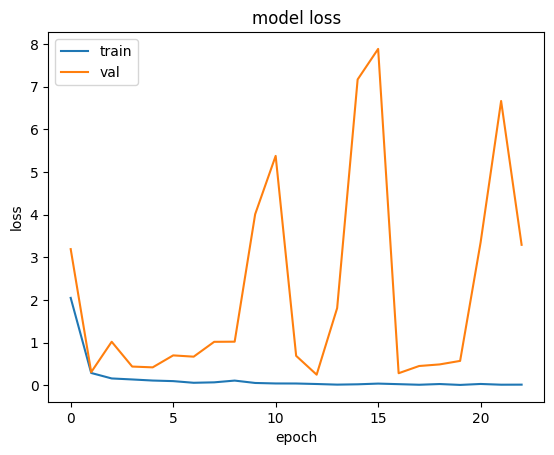

In [11]:
#plot performance by epoch
plot_nn_training(results1)

Baseline Model - With Image Augmentation
This is done to prevent overfitting

In [12]:
model_img = Sequential()

# scaling
#model_img.add(Rescaling(1.0 / 255))

# convolution layers
model_img.add(Conv2D(32, kernel_size=5, strides=2, padding="same", input_shape=(128,128,3)))
model_img.add(BatchNormalization())
model_img.add(Activation("relu"))

model_img.add(Conv2D(64, kernel_size=3, padding="same"))
model_img.add(BatchNormalization())
model_img.add(Activation("relu"))

model_img.add(Conv2D(64, kernel_size=3, padding="same"))
model_img.add(BatchNormalization())
model_img.add(Activation("relu"))

# flatten
model_img.add(Flatten())

# dense layers
model_img.add(Dense(512, activation='relu'))
model_img.add(Dense(256, activation='relu'))
model_img.add(Dense(128, activation='relu'))

# output layer
model_img.add(Dense(2, activation='softmax'))

In [13]:
model_img.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model1/best_model_img.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [14]:
results_img = model_img.fit(
    train_generator,
    steps_per_epoch=100, # num_samples//batch_size
    epochs=50,
    callbacks= [es, mc],
    validation_data=validation_generator,
    validation_steps=20, # num_samples//batch_size
    verbose=4)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to models/Model1/best_model_img.h5
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.50000
Epoch 3/50

Epoch 3: val_accuracy improved from 0.50000 to 0.51600, saving model to models/Model1/best_model_img.h5
Epoch 4/50

Epoch 4: val_accuracy improved from 0.51600 to 0.69450, saving model to models/Model1/best_model_img.h5
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.69450
Epoch 6/50

Epoch 6: val_accuracy improved from 0.69450 to 0.83100, saving model to models/Model1/best_model_img.h5
Epoch 7/50

Epoch 7: val_accuracy improved from 0.83100 to 0.85300, saving model to models/Model1/best_model_img.h5
Epoch 8/50

Epoch 8: val_accuracy improved from 0.85300 to 0.91600, saving model to models/Model1/best_model_img.h5
Epoch 9/50

Epoch 9: val_accuracy did not improve from 0.91600
Epoch 10/50

Epoch 10: val_accuracy did not improve from 0.91600
Epoch 11/50

Epoch 11: val_accuracy did not improve f

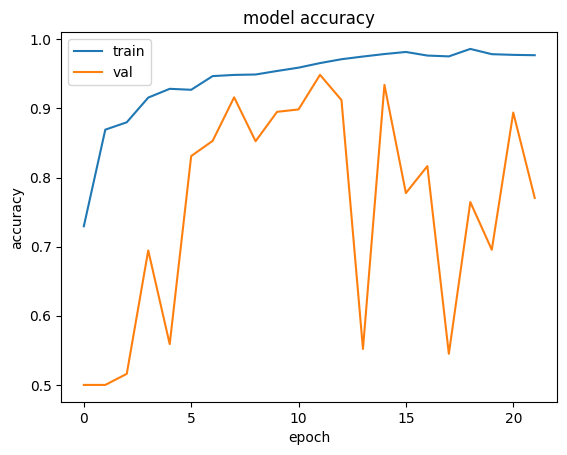

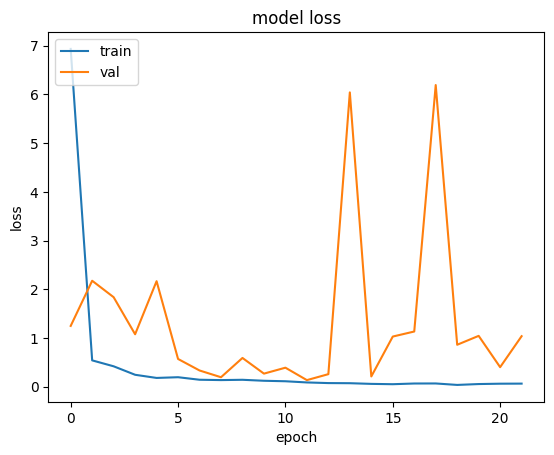

In [15]:
#plot performance by epoch
plot_nn_training(results_img)

Adding Max Pooling and Drop Layers

In [16]:
def generate_model2(input_shape, num_classes):

    '''CNN model architecture with max pooling + dropout layers'''

    inputs = Input(shape=input_shape)

    #x = Rescaling(1.0 / 255)

    # convolution (with max pooling)
    x = Conv2D(32, kernel_size=5, strides=2, padding="same")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    #flatten
    x = Flatten()(x)

    #dense layers (with dropout to avoid overfitting)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)

    # output layer
    output = Dense(2, activation='softmax')(x)

    mod = Model(inputs=inputs, outputs=output)

    return mod

In [17]:
epochs = 100

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model2/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Instantiate model
model2 = generate_model2(input_shape=(128,128,3), num_classes=2)

# Compile model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [18]:
results2 = model2.fit(
    train_generator,
    steps_per_epoch=100, # num_samples//batch_size
    epochs=50,
    callbacks= [es, mc],
    validation_data=validation_generator,
    validation_steps=20, # num_samples//batch_size
    verbose=4)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to models/Model2/best_model.h5
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.50000
Epoch 3/50

Epoch 3: val_accuracy improved from 0.50000 to 0.61500, saving model to models/Model2/best_model.h5
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.61500
Epoch 5/50

Epoch 5: val_accuracy improved from 0.61500 to 0.92850, saving model to models/Model2/best_model.h5
Epoch 6/50

Epoch 6: val_accuracy did not improve from 0.92850
Epoch 7/50

Epoch 7: val_accuracy did not improve from 0.92850
Epoch 8/50

Epoch 8: val_accuracy did not improve from 0.92850
Epoch 9/50

Epoch 9: val_accuracy did not improve from 0.92850
Epoch 10/50

Epoch 10: val_accuracy did not improve from 0.92850
Epoch 11/50

Epoch 11: val_accuracy did not improve from 0.92850
Epoch 12/50

Epoch 12: val_accuracy did not improve from 0.92850
Epoch 13/50

Epoch 13: val_accuracy did not improve from 0.92850
Epoch 14/50

Epoch 14: val_ac

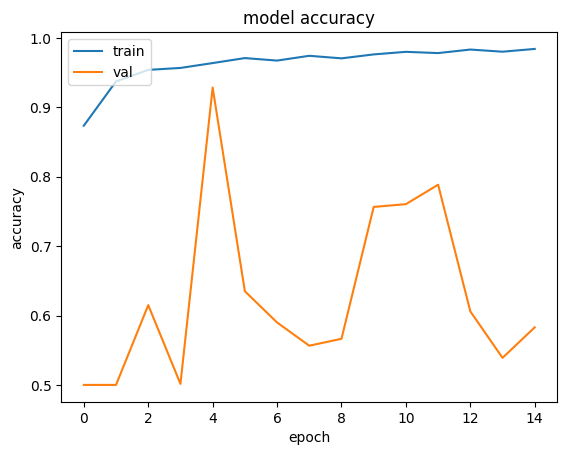

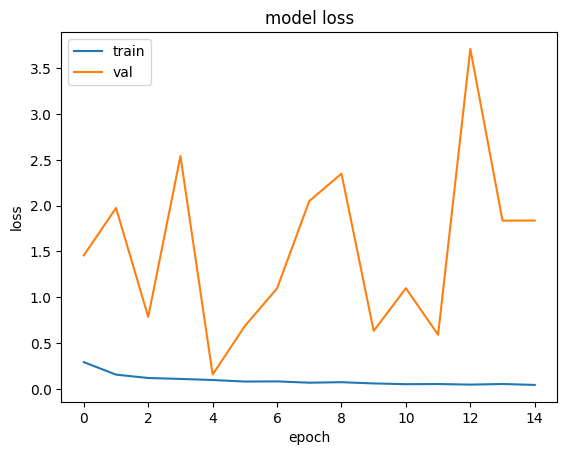

In [19]:
#plot performance by epoch
plot_nn_training(results2)

Transfer Learning

In [20]:
def generate_TL_model(input_shape, num_classes):

    weights = 'imagenet'
    inputs = Input(input_shape)

    #what does include_top=False remove?
    base_model = ResNet50(include_top=False, weights=weights, input_shape=(128, 128, 3))

    #freezing the resnet layers
    for layer in base_model.layers:
        layer.trainable = False

    #these convolution layers come before the resnet layers
    x = Conv2D(32, (5, 5), strides=2, padding='same', activation='relu', input_shape=(128, 128, 3))(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)

    x = Flatten()(x)

    base_resnet = base_model(inputs)
    base_resnet = Flatten()(base_resnet)

    concated_layers = Concatenate()([x, base_resnet])

    # dense layers come after the resnet layers
    # dropout to reduce overfit
    concated_layers = Dense(1024, activation='relu')(concated_layers)
    concated_layers = Dropout(0.3)(concated_layers)
    concated_layers = Dense(512, activation='relu')(concated_layers)
    concated_layers = Dropout(0.2)(concated_layers)
    concated_layers = Dense(256, activation='relu')(concated_layers)
    concated_layers = Dropout(0.1)(concated_layers)

    # output layer
    output = Dense(num_classes, activation='softmax')(concated_layers)

    mod = Model(inputs=inputs, outputs=output)

    return mod

In [21]:
epochs = 100

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model5/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Instantiate model
TL_model = generate_TL_model(input_shape=(128,128,3), num_classes=2)

# Compile model
TL_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

94765736/94765736 [==============================] - 5s 0us/step


In [22]:
results_TL = TL_model.fit(
    train_generator,
    steps_per_epoch=100, # num_samples//batch_size
    epochs=50,
    callbacks= [es, mc],
    validation_data=validation_generator,
    verbose=4,
    validation_steps=20) # num_samples//batch_size

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.74700, saving model to models/Model5/best_model.h5
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.74700
Epoch 3/50

Epoch 3: val_accuracy improved from 0.74700 to 0.80600, saving model to models/Model5/best_model.h5
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.80600
Epoch 5/50

Epoch 5: val_accuracy improved from 0.80600 to 0.84150, saving model to models/Model5/best_model.h5
Epoch 6/50

Epoch 6: val_accuracy did not improve from 0.84150
Epoch 7/50

Epoch 7: val_accuracy improved from 0.84150 to 0.86800, saving model to models/Model5/best_model.h5
Epoch 8/50

Epoch 8: val_accuracy did not improve from 0.86800
Epoch 9/50

Epoch 9: val_accuracy improved from 0.86800 to 0.88800, saving model to models/Model5/best_model.h5
Epoch 10/50

Epoch 10: val_accuracy did not improve from 0.88800
Epoch 11/50

Epoch 11: val_accuracy improved from 0.88800 to 0.89800, saving model to models/Model5/best_model.h5
Epoch 12/50


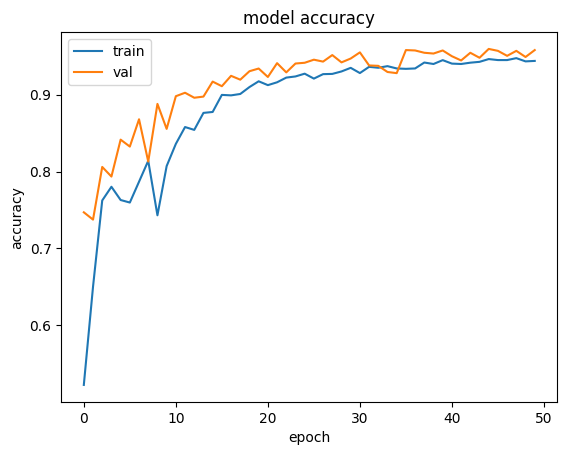

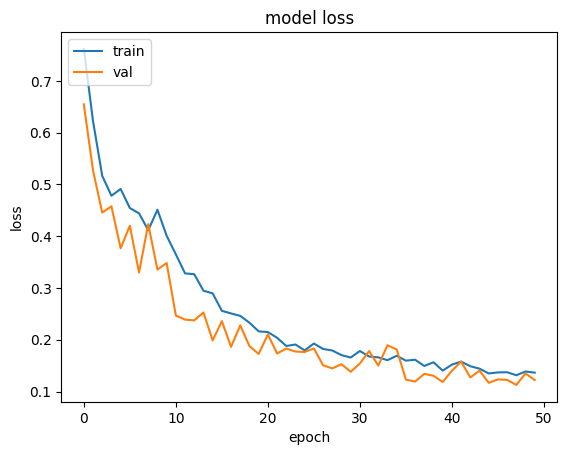

In [23]:

plot_nn_training(results_TL)

TF Model 2 - Reduced learning rating and Convolution Kernel Size

In [24]:
def generate_TL_model_2(input_shape, num_classes):

    '''TL model, Conv kernel=3 '''

    weights = 'imagenet'
    inputs = Input(input_shape)

    #what does include_top=False remove?
    base_model = ResNet50(include_top=False, weights=weights, input_shape=(128, 128, 3))

    #freezing the resnet layers
    for layer in base_model.layers:
        layer.trainable = False

    #these convolution layers come before the resnet layers
    x = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(128, 128, 3))(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)

    x = Flatten()(x)

    base_resnet = base_model(inputs)
    base_resnet = Flatten()(base_resnet)

    concated_layers = Concatenate()([x, base_resnet])

    # dense layers come after the resnet layers
    # dropout to reduce overfit
    concated_layers = Dense(1024, activation='relu')(concated_layers)
    concated_layers = Dropout(0.3)(concated_layers)
    concated_layers = Dense(512, activation='relu')(concated_layers)
    concated_layers = Dropout(0.2)(concated_layers)
    concated_layers = Dense(256, activation='relu')(concated_layers)
    concated_layers = Dropout(0.1)(concated_layers)

    # output layer
    output = Dense(num_classes, activation='softmax')(concated_layers)

    mod = Model(inputs=inputs, outputs=output)

    return mod

In [26]:
epochs = 100

#Adds adam optimizer
adam = tf.keras.optimizers.legacy.Adam(lr=0.0001,
                                beta_1=0.9,
                                beta_2=0.999,
                                decay=0.0,
                                amsgrad=False)

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model5/best_model_tl_smallkernel.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Instantiate model
TL_model_2 = generate_TL_model_2(input_shape=(128,128,3), num_classes=2)

# Compile model
TL_model_2.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [27]:
results_TL_2 = TL_model_2.fit(
    train_generator,
    steps_per_epoch=100, # num_samples//batch_size
    epochs=50,
    callbacks= [es, mc],
    validation_data=validation_generator,
    verbose=4,
    validation_steps=20) # num_samples//batch_size

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.78650, saving model to models/Model5/best_model_tl_smallkernel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50

Epoch 2: val_accuracy improved from 0.78650 to 0.79050, saving model to models/Model5/best_model_tl_smallkernel.h5
Epoch 3/50

Epoch 3: val_accuracy improved from 0.79050 to 0.80850, saving model to models/Model5/best_model_tl_smallkernel.h5
Epoch 4/50

Epoch 4: val_accuracy improved from 0.80850 to 0.83550, saving model to models/Model5/best_model_tl_smallkernel.h5
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.83550
Epoch 6/50

Epoch 6: val_accuracy improved from 0.83550 to 0.87600, saving model to models/Model5/best_model_tl_smallkernel.h5
Epoch 7/50

Epoch 7: val_accuracy improved from 0.87600 to 0.88950, saving model to models/Model5/best_model_tl_smallkernel.h5
Epoch 8/50

Epoch 8: val_accuracy improved from 0.88950 to 0.91150, saving model to models/Model5/best_model_tl_smallkernel.h5
Epoch 9/50

Epoch 9: val_accuracy did not improve from 0.91150
Epoch 10/50

Epoch 10: val_accuracy did not improve from 0.91150
Epoch 11/50

Epoch 11: val_accuracy improved fr

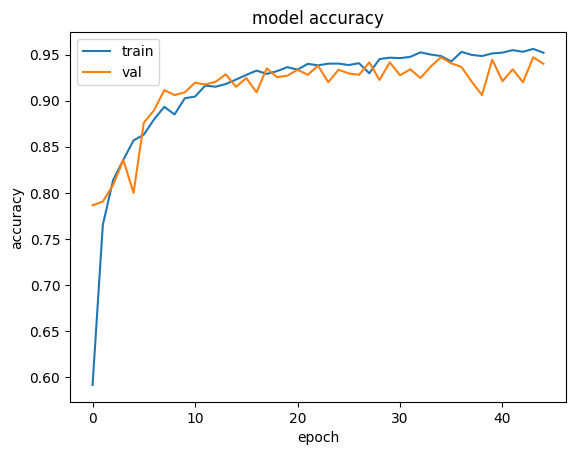

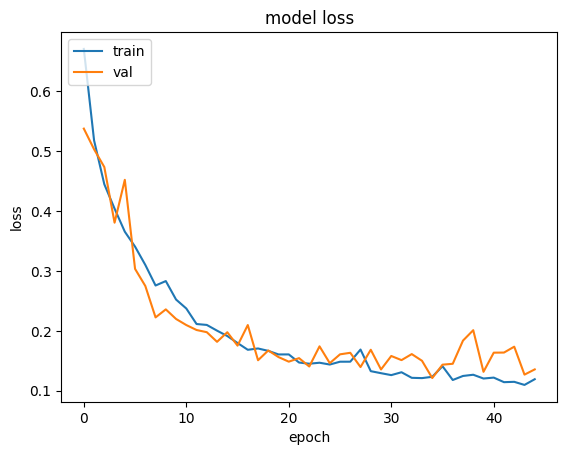

In [28]:
plot_nn_training(results_TL_2)